<a href="https://colab.research.google.com/github/vanessavvp/TFG-nerf-implementation/blob/main/tiny_nerf_mic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
# Eager execution provides an imperative interface to TensorFlow, tf functions execute operations immediately
tf.compat.v1.enable_eager_execution()

# Used for creating Progress Meters or Progress Bars
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2022-03-05 12:19:35--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2022-03-05 12:19:35--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  21.2MB/s    in 0.6s    

2022-03-05 12:19:36 (21.2 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

In [3]:
# from google.colab import drive
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image

root_path = '/content/drive/My Drive/4º Año/TFG/TFG Vanessa Valentina Villalba/Datasets/NeRF_Data/nerf_synthetic/mic/'
N_FILES = 100
rgbaData = []

for i in range(N_FILES):
  actualImgPath = root_path + 'train/r_' + str(i) + '.png'
  rgbaImg = Image.open(actualImgPath, "r").convert("RGBA")
  rgbaImg = rgbaImg.resize((100,100))
  dataImg = np.asarray(rgbaImg)
  dataImg = dataImg.astype(float)
  dataImg = np.divide(dataImg, 255.0)
  rgbaData.append(dataImg)

rgbaData = np.array(rgbaData)
print(rgbaData)

[[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0

In [5]:
import json

# This function takes the path to a json file and returns parsed data
def read_json(jsonPath):
  with open(jsonPath, 'r') as fp:
    data = json.load(fp)
  return data

jsonTrainFile = root_path + 'transforms_train.json'
jsonTrainData = read_json(jsonTrainFile)
poses = []

for i in range(N_FILES):
  transformMatrix = np.array(jsonTrainData['frames'][i]['transform_matrix'])
  poses.append(transformMatrix)

poses = np.array(poses)
# print(poses)

In [6]:
data = np.load('tiny_nerf_data.npz')
# print("Files into data: ", data.files)

# Getting to know the images and poses format
# print("First image content: ", data['images'][0][0][0]) # Images information
# plt.imshow(data['images'][5])
# plt.show()
# print("First pose content: ", data['poses'])  # Camera x, y and z coordinates + rotation?? 
# print("Focal content: ", data['focal']) # Focal lenght?? 


Images shape:  (100, 100, 100, 3) 
Poses shape:  (100, 4, 4) 
focal:  145

HEIGHT:  100 
WIDTH:  100

testImg


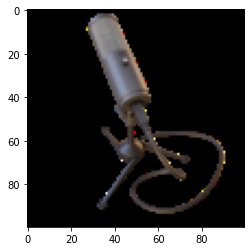


testPose


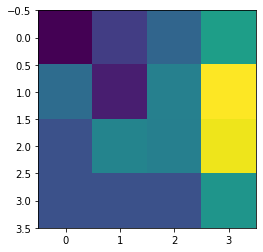

In [7]:
# images = data['images']
# poses = data['poses']
images = rgbaData
# poses = poses
focal = 145
HEIGHT, WIDTH = images.shape[1:3]


images = images[:100,...,:3] # ?
# images = np.resize(images,(100,100,100,4))
testImg, testPose = images[0], poses[0]

print("Images shape: ", images.shape, "\nPoses shape: ", poses.shape, "\nfocal: ", focal)
print("\nHEIGHT: ", HEIGHT, "\nWIDTH: ", WIDTH)
# print("Images content: ", images)
poses = poses[:100]
# print("Poses content: ", poses)

print("\ntestImg")
plt.imshow(testImg)
plt.show()

print("\ntestPose")
plt.imshow(testPose)
plt.show()

# Optimize NeRF

In [8]:
# Positional encoding (Pre-processing step), take coordinates and push them through a bunch of sinusoids of increasing frequency and just expand the feature vector out into a dimensional space with
# a lot of high frequency sinusoids going on, concatenate them all together and then feed that into the neural network. Alows to memorize an image
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))

    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    # rays_d = tf.cast(rays_d, tf.dtypes.float32)
    rays_o = tf.cast(rays_o, tf.dtypes.float32)
    #print(rays_d)
    #print(rays_o)

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples], dtype=tf.dtypes.float32) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.194536075592041 secs per iter


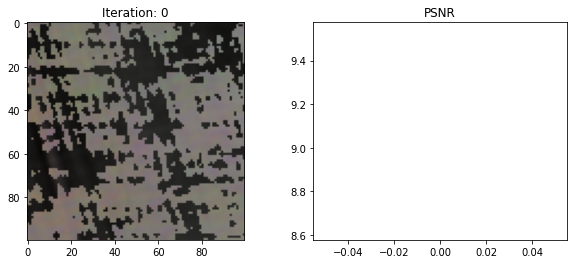

25 2.3548446464538575 secs per iter


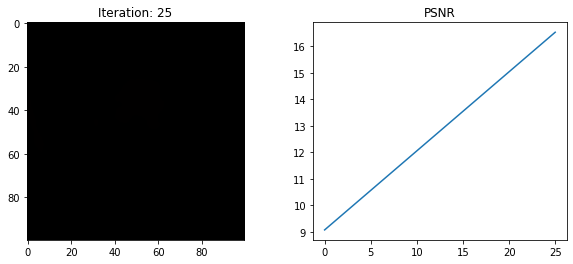

50 2.3496044635772706 secs per iter


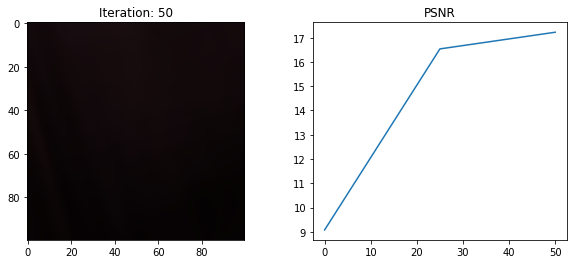

75 2.3501578903198244 secs per iter


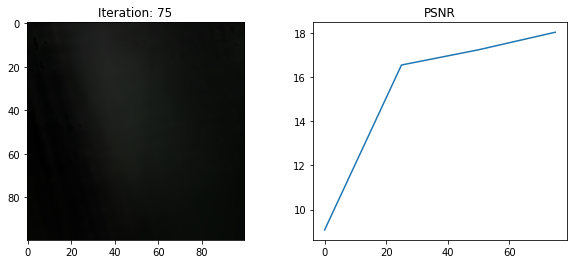

100 2.351278066635132 secs per iter


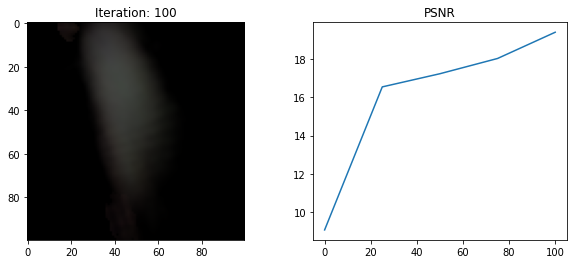

125 2.347125234603882 secs per iter


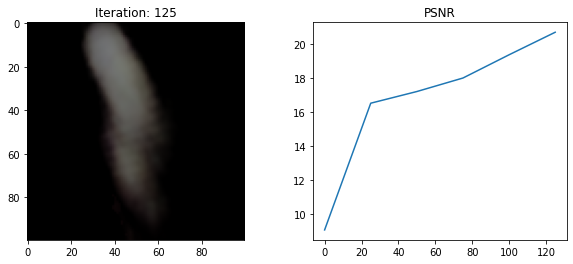

150 2.347442865371704 secs per iter


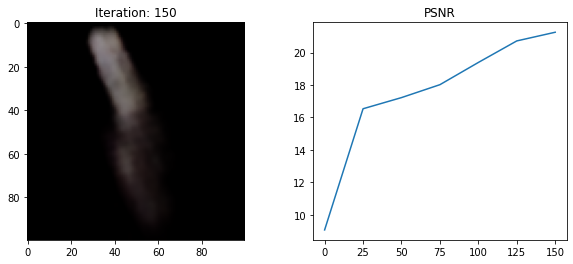

175 2.3465679931640624 secs per iter


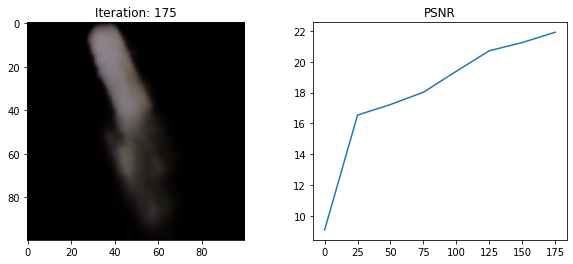

200 2.344113492965698 secs per iter


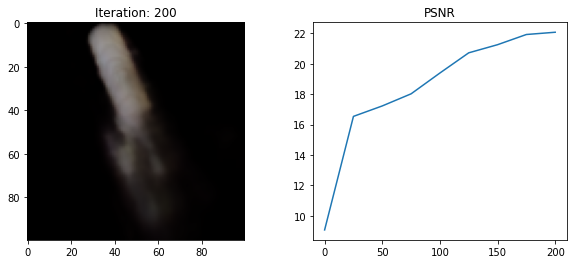

225 2.3448716449737548 secs per iter


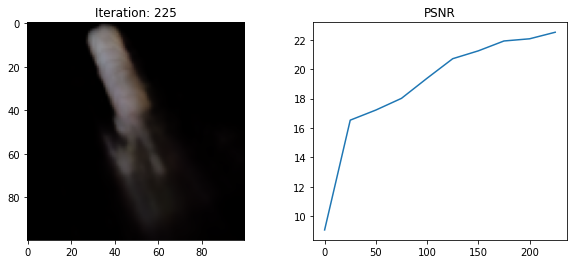

250 2.3516810607910155 secs per iter


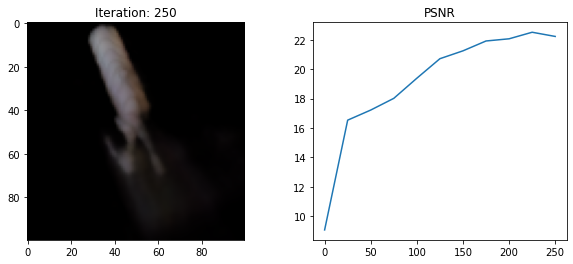

275 2.3465200233459473 secs per iter


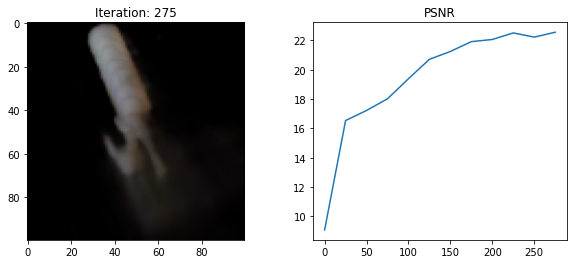

300 2.345650520324707 secs per iter


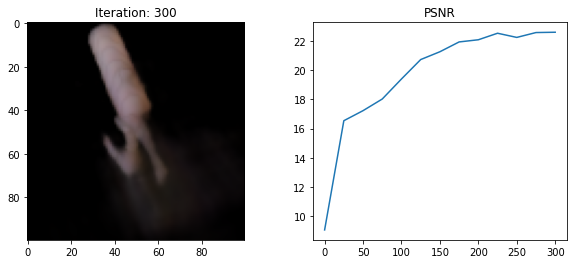

325 2.3479982948303224 secs per iter


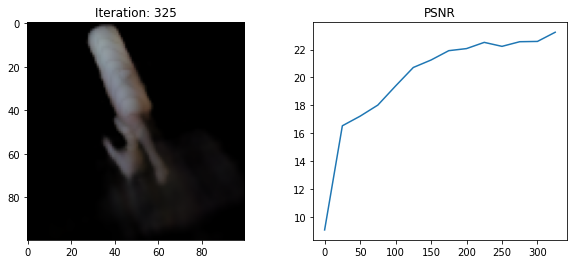

350 2.3476744937896727 secs per iter


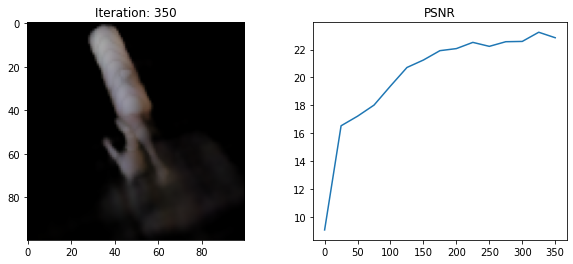

375 2.346195297241211 secs per iter


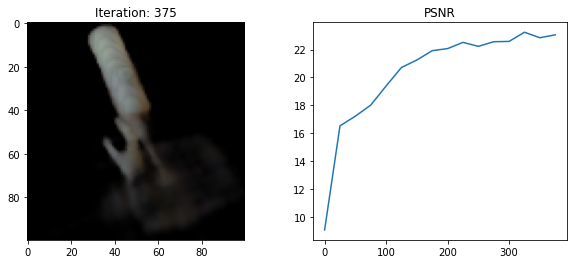

400 2.3474385929107666 secs per iter


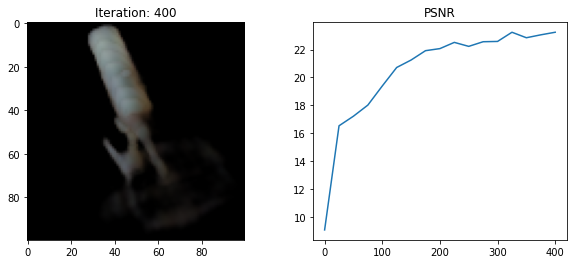

425 2.345516338348389 secs per iter


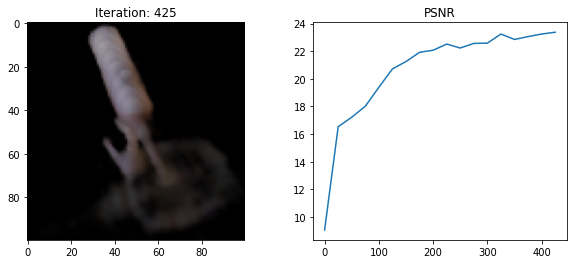

450 2.347670679092407 secs per iter


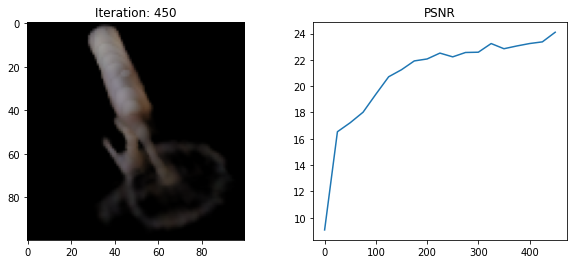

475 2.3465952110290527 secs per iter


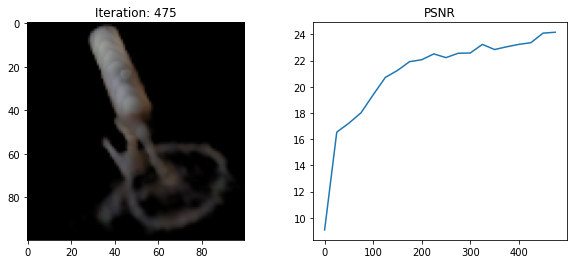

500 2.3457089328765868 secs per iter


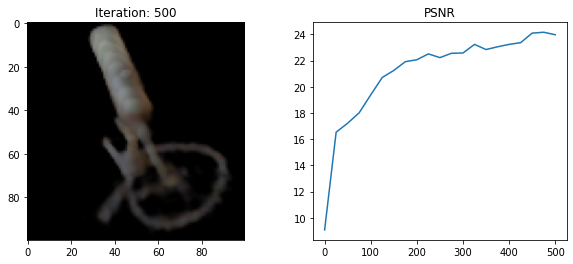

525 2.3454136180877687 secs per iter


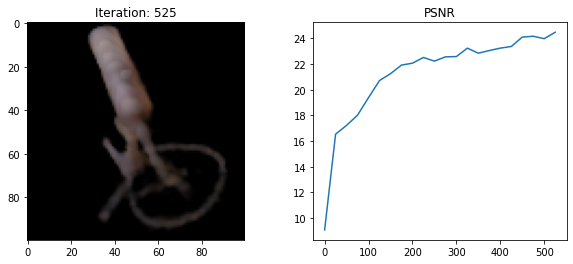

550 2.345588846206665 secs per iter


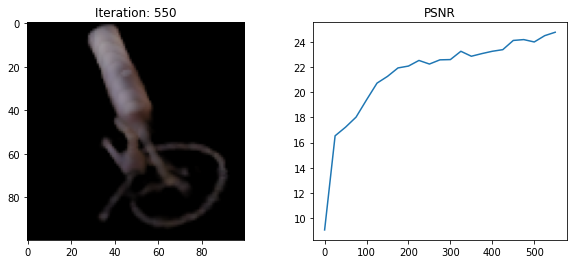

575 2.347170925140381 secs per iter


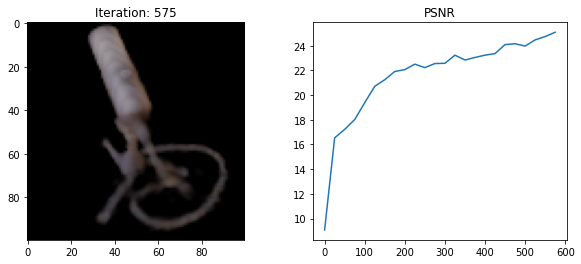

600 2.3482037162780762 secs per iter


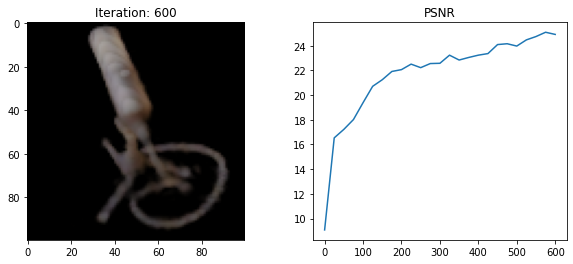

625 2.348444185256958 secs per iter


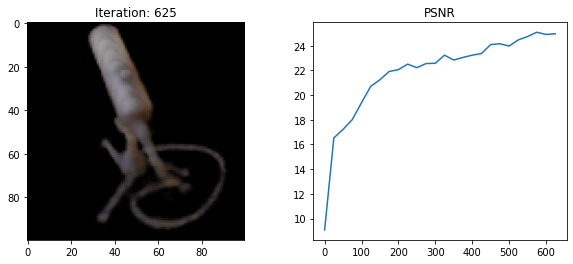

650 2.3470008754730225 secs per iter


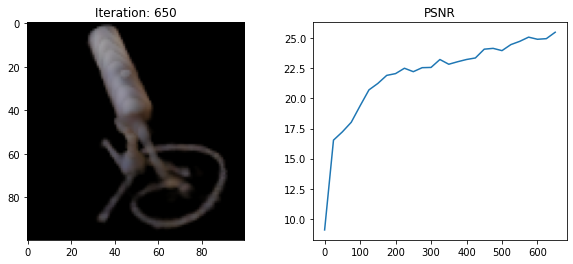

675 2.3479960632324217 secs per iter


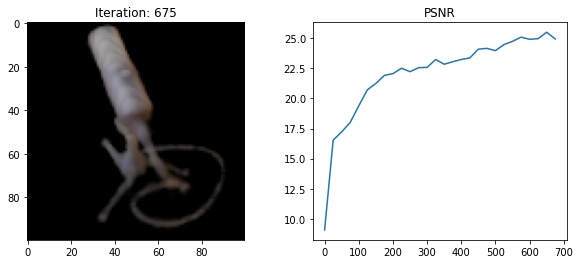

700 2.348161458969116 secs per iter


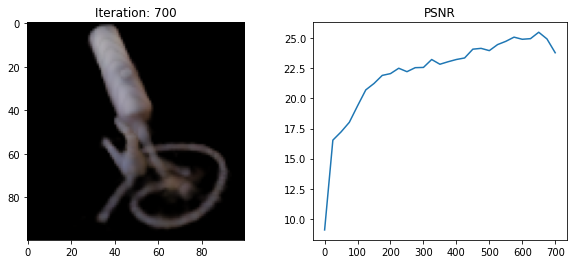

725 2.347463207244873 secs per iter


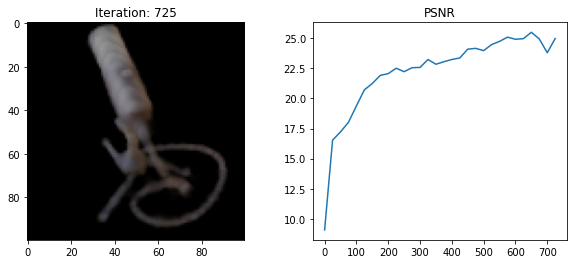

750 2.3461996269226075 secs per iter


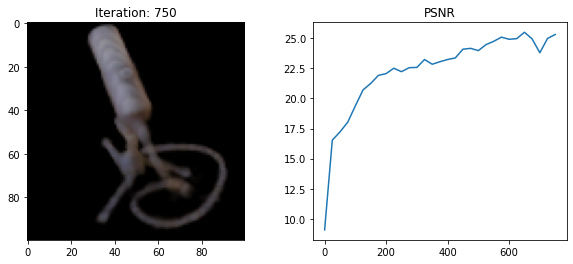

775 2.344446382522583 secs per iter


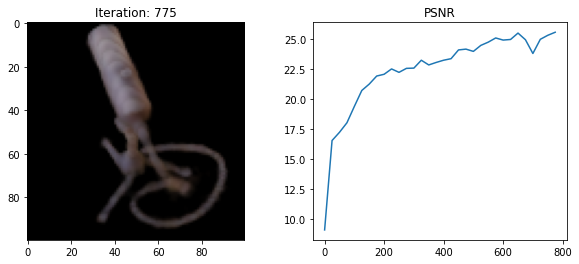

800 2.3458862018585207 secs per iter


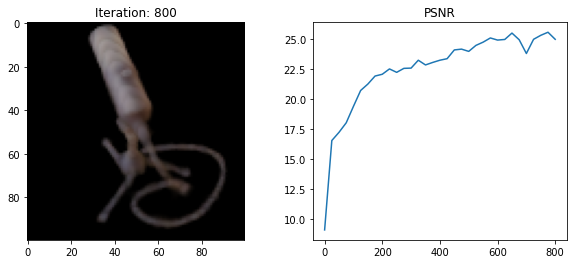

825 2.3458713245391847 secs per iter


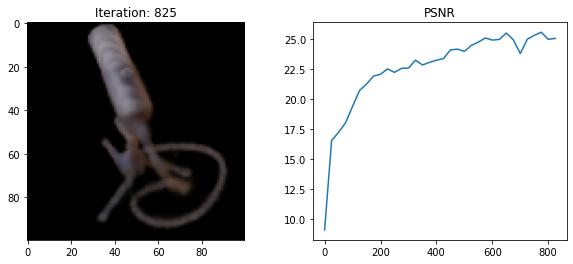

850 2.345509843826294 secs per iter


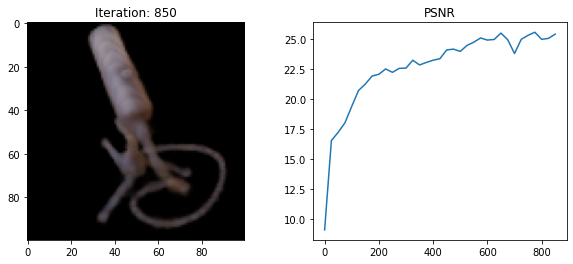

875 2.345204067230225 secs per iter


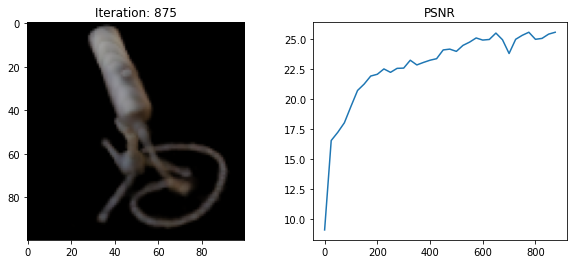

900 2.346989164352417 secs per iter


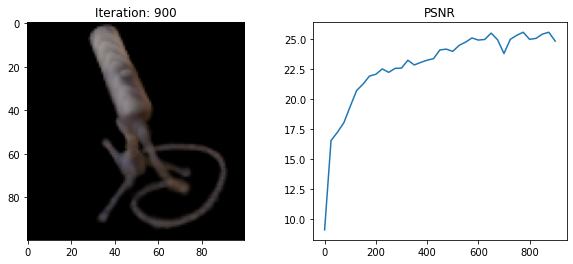

925 2.345755958557129 secs per iter


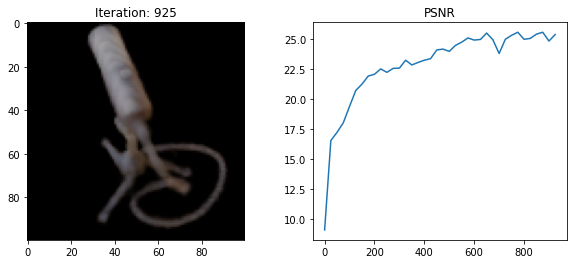

950 2.34695725440979 secs per iter


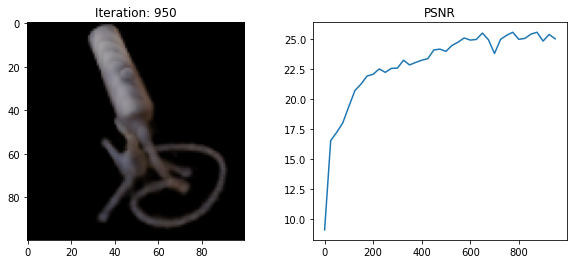

975 2.3451676750183106 secs per iter


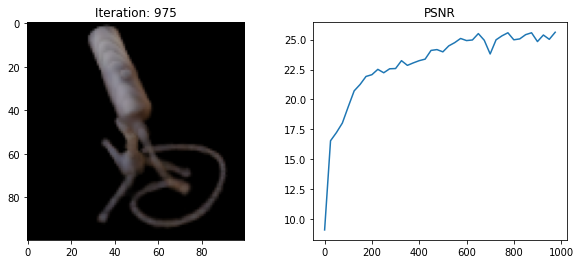

1000 2.3454134368896487 secs per iter


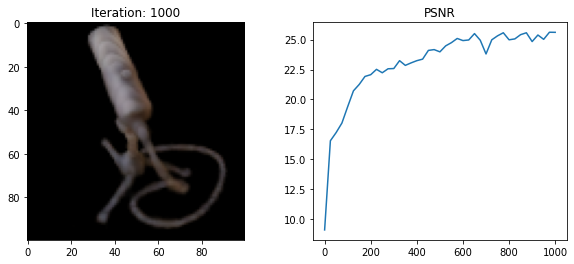

Done


In [9]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, pose)

    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, testPose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testImg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [10]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [11]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)